In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import dgl
import torch
import torch.nn as nn
import torch_geometric
# from torch_geometric import Hetero
import time
import os, datetime
from csv import reader
# Make the graphs a bit prettier, and bigger
# pd.set_option('display.mpl_style', 'default')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

Using backend: pytorch


In [2]:
server_port_profile = dict() # consider in-port of source, source computer act as server
client_port_profile = dict() # consider in-port of destination, source computer act as client

server_port_profile_by_day = dict()
client_port_profile_by_day = dict()

ceiling_day = 30

In [3]:
def auth_filter(row, day_filter):
# day_filter: list of day that used to construct graph. Return True when current row in this list

    day_in_second = 60*60*24
    if np.ceil(int(row[0]) / day_in_second) not in day_filter or row[8] == "Fail" or row[7] == "LogOff" or row[1][0] == "C" or row[2][0] == "C":
#     if np.ceil(int(row[0]) / day_in_second) not in day_filter or row[8] == "Fail" or row[1][0] == "C" or row[2][0] == "C":
        return True
    return False
def process_filter(row, day_filter):
# day_filter: list of day that used to construct graph. Return True when current row in this list

    day_in_second = 60*60*24
    if np.ceil(int(row[0]) / day_in_second) not in day_filter or row[4] == "End":
        return True
    return False

def flow_filter(row, day_filter):
# day_filter: list of day that used to construct graph. Return True when current row in this list

    day_in_second = 60*60*24
    if np.ceil(int(row[0]) / day_in_second) not in day_filter:
#     if np.ceil(int(row[0]) / day_in_second) not in day_filter or row[8] == "Fail" or row[1][0] == "C" or row[2][0] == "C":
        return True
    return False

In [4]:
# print("---------Import flow.txt File --------------")
df_filter = []
start_time = time.time()
# open file in read mode
count = 0
day_in_second = 60*60*24
# day_filter = [2, 3, 6, 7, 8, 9, 10, 13, 14, 15, 16, 21, 22, 23, 27, 28, 29, 30] # only get data from this list of day
day_filter = [i for i in range(1,30)]
important_port = set()

normal_path = set()
with open('/home/andrewngo/Desktop/LANL_data/flows.txt', 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = reader(read_obj)
    # Iterate over each row in the csv using reader object
    for row in csv_reader:
        if flow_filter(row, day_filter):
            continue
        if np.ceil(int(row[0]) / day_in_second) > ceiling_day:
            break        
        
        count = count + 1
        if count % 10000000 == 0:
            print("--- %s seconds ---" % (time.time() - start_time))
            print(str(count/1000000) + "Mth lines")
        time_flow            = row[0]
        duration             = row[1]
        source_computer      = row[2]
        source_port          = row[3]
        destination_computer = row[4]
        destination_port     = row[5]
        protocol             = row[6]
        packet_count         = row[7]
        byte_count           = row[8]
        
#“time,duration,1r,destination port,protocol,packet count,byte count”
        
# Add server profile port
# add server profile for source computer
#         if source_computer not in server_port_profile:
#             server_port_profile[source_computer] = dict()

#         if source_port not in server_port_profile[source_computer]:
#             server_port_profile[source_computer][source_port] = 1
#         else:
#             server_port_profile[source_computer][source_port] += 1
# add server profile for destination computer
        if destination_computer not in server_port_profile:
            server_port_profile[destination_computer] = dict()
            
        if destination_port not in server_port_profile[destination_computer]:
            server_port_profile[destination_computer][destination_port] = 1
        else:
            server_port_profile[destination_computer][destination_port] += 1
        
        

# Add client profile port for source computer
        if source_computer not in client_port_profile:
            client_port_profile[source_computer] = dict()
            
        if destination_port not in client_port_profile[source_computer]:
            client_port_profile[source_computer][destination_port] = 1
        else:
            client_port_profile[source_computer][destination_port] += 1
        
        if source_port[0] != "N":
            important_port.add(source_port)
        if destination_port[0] != "N":
            important_port.add(destination_port)
            
# df = pd.DataFrame (df)
# df

--- 50.25218939781189 seconds ---
10.0Mth lines
--- 105.82188773155212 seconds ---
20.0Mth lines
--- 185.31263422966003 seconds ---
30.0Mth lines
--- 236.74764275550842 seconds ---
40.0Mth lines
--- 288.67286944389343 seconds ---
50.0Mth lines
--- 338.2101023197174 seconds ---
60.0Mth lines
--- 393.92043471336365 seconds ---
70.0Mth lines
--- 448.1519672870636 seconds ---
80.0Mth lines
--- 502.82087683677673 seconds ---
90.0Mth lines
--- 558.9043934345245 seconds ---
100.0Mth lines
--- 618.0223100185394 seconds ---
110.0Mth lines
--- 678.0385067462921 seconds ---
120.0Mth lines


In [53]:
#port profile

In [7]:
def delete_random_port(port_profile):
    for i in port_profile:
        new_profile = dict()
        for j in port_profile[i]:
            if j[0] != "N":
#                 print(j)
                new_profile[j] = port_profile[i][j]
        port_profile[i] = new_profile
    return port_profile
def proportional_profile(port_profile):
    for i in port_profile:
        new_profile = dict()
        sum_values = sum(port_profile[i].values())
        for j in port_profile[i]:
            new_profile[j] = port_profile[i][j]/sum_values
        port_profile[i] = new_profile
    return port_profile

In [8]:
import copy
new_server_port_profile = copy.deepcopy(server_port_profile)
new_client_port_profile = copy.deepcopy(client_port_profile)


new_server_port_profile = delete_random_port(new_server_port_profile)
new_client_port_profile = delete_random_port(new_client_port_profile)

In [9]:
# only consider some of the most importance port (for server profile only)
new_server_port_profile
cutoff_value = 3
min_frequency = 10
for i in new_server_port_profile:
    new_profile_dict = dict()
    profile_list = sorted(new_server_port_profile[i].items(), key=lambda item: item[1], reverse = True)
    if len(profile_list) != 0:
        previous_count = profile_list[0][1]
        new_profile_dict[profile_list[0][0]] = profile_list[0][1]
        for j in range(1,len(profile_list)):
            if profile_list[j][1] < previous_count/cutoff_value or profile_list[j][1] < min_frequency :
                break
            previous_count = profile_list[j][1]
            new_profile_dict[profile_list[j][0]] = profile_list[j][1]
    new_server_port_profile[i] = new_profile_dict
            
new_server_port_profile


{'C3799': {'137': 166},
 'C1707': {'80': 997},
 'C5720': {'445': 8907019},
 'C1423': {'137': 392, '22': 194, '80': 194, '123': 146},
 'C925': {'445': 3},
 'C528': {'389': 297374, '445': 242969, '88': 139108, '135': 54107},
 'C1065': {'389': 494725, '445': 355111, '88': 253904, '135': 91745},
 'C585': {'445': 1171586, '139': 567115},
 'C3587': {'137': 159, '123': 88},
 'C14909': {'751': 9},
 'C7632': {'22': 18, '80': 16},
 'C1799': {'6004': 2},
 'C4254': {'137': 461},
 'C14005': {'1080': 3},
 'C3420': {'123': 24},
 'C3371': {'4899': 3},
 'C5030': {'443': 457191},
 'C4316': {'137': 173},
 'C5721': {'445': 10918886},
 'C1554': {'137': 24},
 'C1685': {'80': 1881},
 'C2683': {'445': 32423},
 'C500': {'445': 8},
 'C172': {'137': 1},
 'C770': {'137': 1},
 'C1294': {'137': 3},
 'C5736': {'445': 597579},
 'C11573': {'111': 67956},
 'C1587': {'445': 20},
 'C2270': {'22': 246,
  '80': 190,
  '777': 129,
  '765': 87,
  '754': 82,
  '750': 79,
  '749': 74,
  '760': 68,
  '808': 50,
  '751': 48,
  '

In [12]:
new_server_port_profile["C17693"]

{'57000': 1.0}

In [11]:
prop_server_port_profile = proportional_profile(new_server_port_profile)
prop_client_port_profile = proportional_profile(new_client_port_profile)

In [60]:
# proportional embedding feature

temp = list(important_port)
temp = sorted(temp, key=lambda x: int(x))

index_list = list(set(list(new_server_port_profile.keys()) + list(new_client_port_profile.keys())))
index_dict = {index_list[i]:i for i in range(len(index_list))}

df_profile_server = pd.DataFrame(float(0), index=np.arange(len(index_list)), columns=temp)
df_profile_client = pd.DataFrame(float(0), index=np.arange(len(index_list)), columns=temp)
# add server port profile
for i in prop_server_port_profile:
    index = index_dict[i]
    for j in prop_server_port_profile[i]:
        df_profile_server.at[index, str(j)] = prop_server_port_profile[i][j]


# add client port profile
for i in prop_client_port_profile:
    index = index_dict[i]
    for j in prop_client_port_profile[i]:
        df_profile_client.at[index, str(j)] = prop_client_port_profile[i][j]

df_profile_server.to_csv("server_profile_prop.csv", index = False)
df_profile_client.to_csv("client_profile_prop.csv", index = False)

In [62]:
# binary embedding feature (if port open then 1, else 0)

temp = list(important_port)
temp = sorted(temp, key=lambda x: int(x))

index_list = list(set(list(new_server_port_profile.keys()) + list(new_client_port_profile.keys())))
index_dict = {index_list[i]:i for i in range(len(index_list))}

df_profile_server = pd.DataFrame(float(0), index=np.arange(len(index_list)), columns=temp)
df_profile_client = pd.DataFrame(float(0), index=np.arange(len(index_list)), columns=temp)
# add server port profile
for i in new_server_port_profile:
    index = index_dict[i]
    for j in new_server_port_profile[i]:
        df_profile_server.at[index, str(j)] = 1


# add client port profile
for i in new_client_port_profile:
    index = index_dict[i]
    for j in new_client_port_profile[i]:
        df_profile_client.at[index, str(j)] = 1

df_profile_server.to_csv("server_profile_bin.csv", index = False)
df_profile_client.to_csv("client_profile_bin.csv", index = False)

In [63]:
index_dict_rev = {i:index_list[i] for i in range(len(index_list))}

new_server_port_profile[index_dict_rev[4733]]

KeyError: 'C3098'

In [2]:
def eliminate_unimportance_port(df_profile, list_keep):
    df_profile = df_profile[list_keep]
    return df_profile
#     df_profile = df_profile.drop('column_name', 1)

In [66]:


# textfile = open("port_list.txt", "w")
# for element in keep_list:
#     textfile.write(element + "\n")
# textfile.close()

In [3]:
# merge server and client features
df_profile_server_prop = pd.read_csv("server_profile_prop.csv")
drop_list = [60179, 60177, 57000, 13722, 15345, 17003, 17004, 20011, 20012, 22125, 22128, 22273, 27374, 30865, 10080, 9673, 9359, 9098]
drop_list = [str(i) for i in drop_list]
drop_list = set(drop_list)
keep_list = list(df_profile_server_prop.columns)
keep_list = [str(i) for i in keep_list if i not in drop_list]
df_profile_server_prop = eliminate_unimportance_port(df_profile_server_prop, keep_list)



new_columns = df_profile_server_prop.columns
new_columns = [i + "_server" for i in new_columns]
df_profile_server_prop.columns = new_columns

df_profile_client_prop = pd.read_csv("client_profile_prop.csv")
new_columns = df_profile_client_prop.columns
new_columns = [i + "_client" for i in new_columns]
df_profile_client_prop.columns = new_columns

df_profile_all_prop = pd.concat([df_profile_server_prop, df_profile_client_prop.reindex(df_profile_server_prop.index)], axis=1)
df_profile_all_prop

# df_profile_server_bin = pd.read_csv("server_profile_bin.csv")
# df_profile_client_bin = pd.read_csv("client_profile_bin.csv")
df_profile_server_bin = pd.read_csv("server_profile_bin.csv")
drop_list = [60179, 60177, 57000, 13722, 15345, 17003, 17004, 20011, 20012, 22125, 22128, 22273, 27374, 30865, 10080, 9673, 9359, 9098]
drop_list = [str(i) for i in drop_list]
drop_list = set(drop_list)
keep_list = [str(i) for i in keep_list if i not in drop_list]
df_profile_server_bin = eliminate_unimportance_port(df_profile_server_bin, keep_list)
new_columns = df_profile_server_bin.columns
new_columns = [i + "_server" for i in new_columns]
df_profile_server_bin.columns = new_columns

df_profile_client_bin = pd.read_csv("client_profile_bin.csv")
new_columns = df_profile_client_bin.columns
new_columns = [i + "_client" for i in new_columns]
df_profile_client_bin.columns = new_columns

df_profile_all_bin = pd.concat([df_profile_server_bin, df_profile_client_bin.reindex(df_profile_server_bin.index)], axis=1)

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
# from yellowbrick.cluster import KElbowVisualizer

For n_clusters = 2 The average silhouette_score is : 0.39139332466057547
For n_clusters = 3 The average silhouette_score is : 0.3926735509654895
For n_clusters = 4 The average silhouette_score is : 0.42963805466404204
For n_clusters = 5 The average silhouette_score is : 0.45901333483397994
For n_clusters = 6 The average silhouette_score is : 0.4839796798262433
For n_clusters = 7 The average silhouette_score is : 0.4954629803086131
For n_clusters = 8 The average silhouette_score is : 0.5102685098442986
For n_clusters = 9 The average silhouette_score is : 0.5224751289039962
For n_clusters = 10 The average silhouette_score is : 0.527666651259405
For n_clusters = 11 The average silhouette_score is : 0.5433773564851928
For n_clusters = 12 The average silhouette_score is : 0.5501946071746499
For n_clusters = 13 The average silhouette_score is : 0.558699345207144
For n_clusters = 14 The average silhouette_score is : 0.5585668834012698
For n_clusters = 15 The average silhouette_score is : 0.56

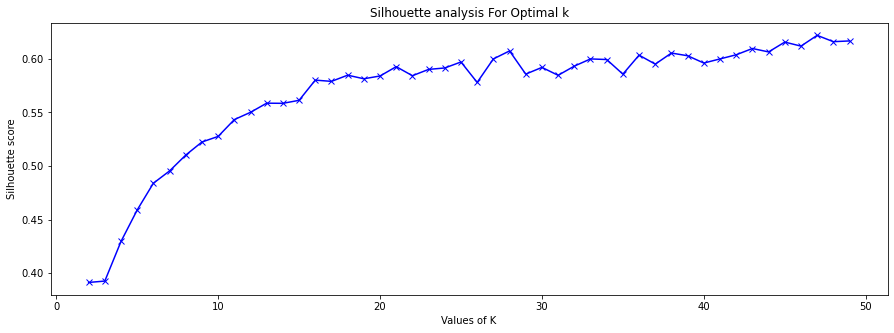

In [5]:
range_n_clusters = [i for i in range(2,50)]
silhouette_avg = []
X = df_profile_all_prop
for num_clusters in range_n_clusters:
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, random_state = 10)
    kmeans.fit(X)
    cluster_labels = kmeans.labels_
    print(
        "For n_clusters =",
        num_clusters,
        "The average silhouette_score is :",
        silhouette_score(X, cluster_labels),
    )
    silhouette_avg.append(silhouette_score(X, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg,"bx-")
plt.xlabel("Values of K") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k")
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.455965835280203
For n_clusters = 3 The average silhouette_score is : 0.5528116392258808
For n_clusters = 4 The average silhouette_score is : 0.5556586570722545
For n_clusters = 5 The average silhouette_score is : 0.6189226681353002
For n_clusters = 6 The average silhouette_score is : 0.6765906395341291
For n_clusters = 7 The average silhouette_score is : 0.6904179148693738
For n_clusters = 8 The average silhouette_score is : 0.7027185380689033
For n_clusters = 9 The average silhouette_score is : 0.7146215695162387
For n_clusters = 10 The average silhouette_score is : 0.7240771644124253
For n_clusters = 11 The average silhouette_score is : 0.7367582489522176
For n_clusters = 12 The average silhouette_score is : 0.7176016382276246
For n_clusters = 13 The average silhouette_score is : 0.7276022854328221
For n_clusters = 14 The average silhouette_score is : 0.7414929759312922
For n_clusters = 15 The average silhouette_score is : 0.7369

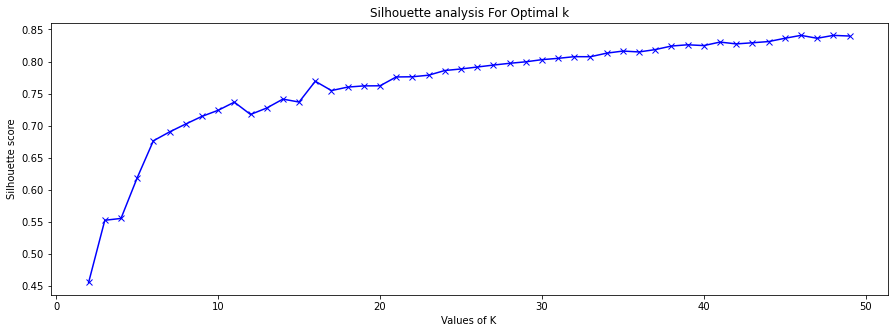

In [70]:
range_n_clusters = [i for i in range(2,50)]
silhouette_avg = []
X = df_profile_server_prop
for num_clusters in range_n_clusters:
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, random_state = 10)
    kmeans.fit(X)
    cluster_labels = kmeans.labels_
    print(
        "For n_clusters =",
        num_clusters,
        "The average silhouette_score is :",
        silhouette_score(X, cluster_labels),
    )
    silhouette_avg.append(silhouette_score(X, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg,"bx-")
plt.xlabel("Values of K") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k")
plt.show()

In [35]:
range_n_clusters = [i for i in range(100,10000,500)]
silhouette_avg = []
X = df_profile_server_bin
for num_clusters in range_n_clusters:
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X)
    cluster_labels = kmeans.labels_
    print(
        "For n_clusters =",
        num_clusters,
        "The average silhouette_score is :",
        silhouette_score(X, cluster_labels),
    )
    silhouette_avg.append(silhouette_score(X, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg,"bx-")
plt.xlabel("Values of K") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k")
plt.show()

For n_clusters = 100 The average silhouette_score is : 0.7099185310825425
For n_clusters = 600 The average silhouette_score is : 0.7817017392479175
For n_clusters = 1100 The average silhouette_score is : 0.8804692645343687


<ipython-input-35-bd90bc0994cb>:7: ConvergenceWarning: Number of distinct clusters (1353) found smaller than n_clusters (1600). Possibly due to duplicate points in X.
  kmeans.fit(X)


For n_clusters = 1600 The average silhouette_score is : 0.8951217337019531


<ipython-input-35-bd90bc0994cb>:7: ConvergenceWarning: Number of distinct clusters (1353) found smaller than n_clusters (2100). Possibly due to duplicate points in X.
  kmeans.fit(X)


For n_clusters = 2100 The average silhouette_score is : 0.8951217337019531


KeyboardInterrupt: 

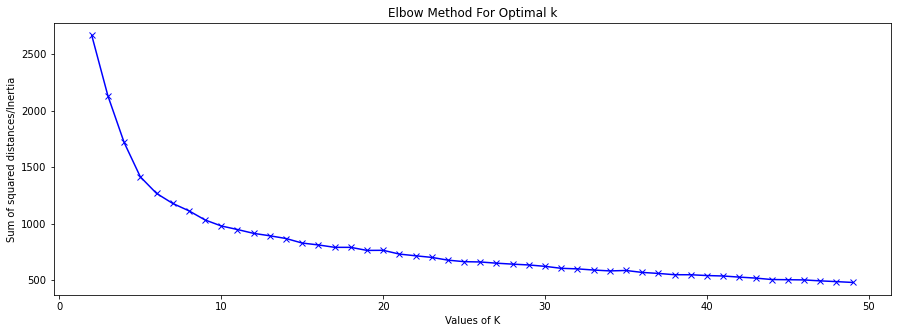

In [29]:
Sum_of_squared_distances = []
range_n_clusters = [i for i in range(2,50)]
X = df_profile_server_prop

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X)
    Sum_of_squared_distances.append(kmeans.inertia_)
    
plt.plot(range_n_clusters,Sum_of_squared_distances,"bx-")
plt.xlabel("Values of K") 
plt.ylabel("Sum of squared distances/Inertia") 
plt.title("Elbow Method For Optimal k")
plt.show()

For n_clusters = 30 The average silhouette_score is : 0.8029319282945651


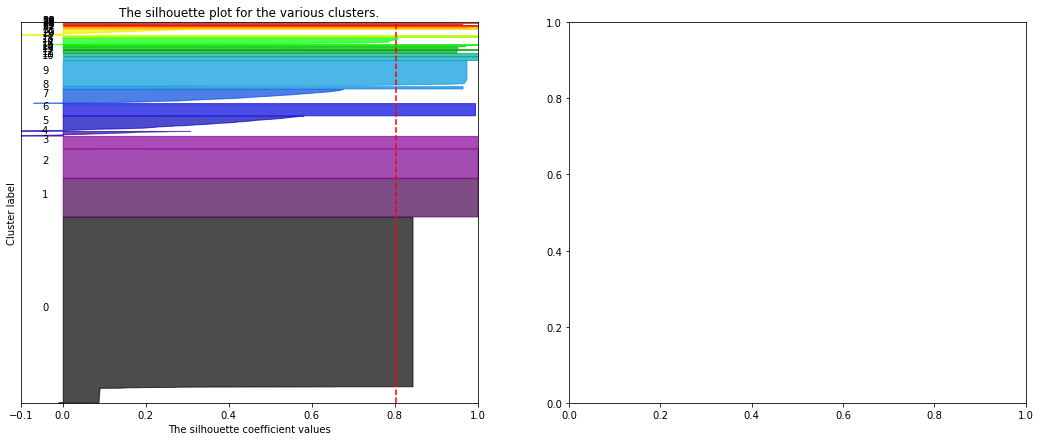

In [71]:
range_n_clusters = [i for i in range(30,31)]
X = df_profile_server_prop
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [72]:
cluster_labels

array([20,  0, 21, ...,  2,  0,  0], dtype=int32)

In [73]:
df_profile_server_prop["profile_labels"] = cluster_labels
# index_list = list(set(list(new_server_port_profile.keys()) + list(new_server_port_profile.keys())))
df_profile_server_prop["computer"] = index_list
df_profile_server_prop = df_profile_server_prop.sort_values("profile_labels")
df_profile_server_prop.to_csv("server_profile_prop_labels_30.csv", index = False)


In [30]:
df_profile_server_bin["profile_labels"] = cluster_labels
# index_list = list(set(list(new_server_port_profile.keys()) + list(new_server_port_profile.keys())))
df_profile_server_bin["computer"] = index_list
df_profile_server_bin = df_profile_server_bin.sort_values("profile_labels")
df_profile_server_bin.to_csv("server_profile_bin_labels.csv", index = False)


In [28]:
index_list

['C18117',
 'C23705',
 'C2299',
 'C10794',
 'C25',
 'C909',
 'C25544',
 'C2393',
 'C7608',
 'C26282',
 'C1579',
 'C4755',
 'C8470',
 'C22094',
 'C925',
 'C614',
 'C20420',
 'C21312',
 'C12796',
 'C8367',
 'C23177',
 'C24735',
 'C6064',
 'C13935',
 'C19690',
 'C418',
 'C24590',
 'C14000',
 'C2121',
 'C7251',
 'C54',
 'C24710',
 'C385',
 'C25201',
 'C1767',
 'C4436',
 'C13473',
 'C9997',
 'C18945',
 'C10907',
 'C11167',
 'C16610',
 'C13748',
 'C5924',
 'C20116',
 'C6037',
 'C10331',
 'C12349',
 'C16877',
 'C11990',
 'C14182',
 'C25241',
 'C17933',
 'C24051',
 'C20145',
 'C578',
 'C12263',
 'C21060',
 'C545',
 'C15146',
 'C11392',
 'C18783',
 'C17363',
 'C11023',
 'C18504',
 'C22029',
 'C10609',
 'C16422',
 'C8462',
 'C5306',
 'C2004',
 'C838',
 'C322',
 'C10423',
 'C9215',
 'C3854',
 'C18608',
 'C9799',
 'C14122',
 'C16957',
 'C12240',
 'C2193',
 'C3978',
 'C11071',
 'C1416',
 'C620',
 'C1409',
 'C26562',
 'C27016',
 'C19380',
 'C21790',
 'C9756',
 'C22414',
 'C3471',
 'C21828',
 'C8133'

In [ ]:
index_dict["C1065"]

In [ ]:
cluster_labels

In [ ]:
range_n_clusters = [i for i in range(35, 36)]
X = df_profile_server_prop
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(X)
    centers = clusterer.cluster_centers_

    score = silhouette_score(X, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    


In [ ]:
y_km 

In [ ]:
plt.scatter(
    X[y_km == 0, 0], X[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X[y_km == 1, 0], X[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    X[y_km == 2, 0], X[y_km == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()